# 1. 数据处理
## 1.1 对于txt数据的处理
1. 处理txt：每100ms上报一个数据，每个数据包含多个字段，详见论文的APPENDIXES B – DATASET INFO；但我们用得到的主要就是以下3个字段：EpochTime\BufferHealth\PlaybackQuality

2. | Relative Time| Packets Sent |Packets Sent|Bytes Sent|Bytes Received|[NetworkInfo N]|[Playback Info]
| --- | --- |---|
|相对时间标志着间隔的结束| 1|1|1|1| 7x26|4+4+9+3

3. 其中`NetworkInfo N`中包含7和字段，一共有26组
4. `Playback Info`中有4+4+9+3个字段，是我们需要注意的分类标签

In [9]:
import glob

import numpy as np
import pandas as pd
import os

## 清理原始数据

In [10]:
# 清理原始数据
# 规范：全局变量使用首字母大写
Dataset_List = ['A0', 'A1', 'A2', 'A3']
Datasets_Folder = "RequetDataSetNew"
Data_Num_In_Folder = {
    'A0':95,
    'A1':130,
    'A2':91,
    'A3':119
}
Label_Folder = "LabelDataSet"

for datasets in Dataset_List:
    dataset_folder = f'{Datasets_Folder}/{datasets}/MERGED_FILES/'
    files = glob.glob(dataset_folder + '*.csv')
    for file in files:
        # print(file)
        os.remove(file)

In [5]:
# 构建前五个col
COLS = ['RelativeTime', 'PacketsSent', 'PacketsReceived', 'BytesSent', 'BytesReceived']
Network_Info_Num = 26 # 一共26个NetworkINFO
for i in range(0, Network_Info_Num):
    ss = str(i)
    Network_Info = ['IPSrc' + ss,
                    'IPDst' + ss,
                    'Protocol' + ss,
                    'PacketsSent' + ss,
                    'PacketsReceived' + ss,
                    'BytesSent' + ss,
                    'BytesReceived' + ss]
    COLS.extend(Network_Info)
COLS.extend(['Buffering', 'Paused', 'Playing', 'CollectData']);
COLS.extend(['EpochTime','StartTime', 'PlaybackProgress', 'Length']);
COLS.extend(['UnlabelledQuality', 'q144p', 'q240p','q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']);
COLS.extend(['BufferHealth', 'BufferProgress', 'BufferValid'])
# 验证构建正确性
TARGET_NUM_COLS = 5 + 7 * 26 + (4 + 4 + 9 + 3)
if len(COLS) != TARGET_NUM_COLS:
    raise Exception(f"Error number of columns {len(COLS)}, targat columns is {TARGET_NUM_COLS} ")
else:
    print(f"Succeed to construct COL:{len(COLS)}")


Succeed to construct COL:207


## 1.2 加载txt

In [87]:
import concurrent.futures
MAX_WORKERS = 20
def Conactenat(file):
    csv_filename = f"{Label_Folder}/{datasets}/{os.path.split(file)[1]}".split('.')[0] + ".csv"
    # print(csv_filename)
    origin_file = open(file, "rt")
    csv_file = open(csv_filename, "wt")
    for line in origin_file:
        csv_file.write(line.replace('[', '').replace(']', ''))
    origin_file.close()
    csv_file.close()
    df = pd.read_csv(csv_filename, header=None, low_memory=False)
    df.columns = 207
    df.to_csv(csv_filename, index=False)
    # percent = round(1.0 * i / total * 100,2)
    # print(f'Concatenating{datasets} : {str(percent)}% ,[{i}/{total}]',end='\r')
    # i = i + 1

In [6]:
### 等会删掉
import time
Dataset_List = ['A0']
###
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Datasets_Folder}/{datasets}/MERGED_FILES/'
    files = glob.glob(dataset_folder + '*_*_merged.txt')
    if len(files) != Data_Num_In_Folder[datasets]:
        raise Exception(f"Error File Num,Please Check Folder :{dataset_folder}")
    else:
        print(f"Folder : {dataset_folder} , File Num : {len(files)}")
    i = 1
    os.system(f"md {Label_Folder}\\{datasets}")
    total = len(files)
    for file in files:
        csv_filename = f"{Label_Folder}/{datasets}/{os.path.split(file)[1]}".split('.')[0] + ".csv"
        # print(csv_filename)
        origin_file = open(file, "rt")
        csv_file = open(csv_filename, "wt")
        for line in origin_file:
            csv_file.write(line.replace('[', '').replace(']', ''))
        origin_file.close()
        csv_file.close()
        df = pd.read_csv(csv_filename, header=None, low_memory=False)
        df.columns = COLS
        # print("Concatenating (", i, "/", len(files), "): ", file)
        df.to_csv(csv_filename, index=False)
        percent = round(1.0 * i / total * 100,2)
        print(f'Concatenating{datasets} : {str(percent)}% ,[{i}/{total}]',end='\r')
        i = i + 1
print("******Concatenated All Folder!*******")
end = time.time()
print(f"Use {end - start}s")


Folder : RequetDataSetNew/A0/MERGED_FILES/ , File Num : 95
******Concatenated All Folder!*******
Use 35.65719985961914s


In [170]:
# ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']状态对照表
def smooth_status(status_origin, m_t):
    # print("SMOOTH")
    status_smooth = status_origin.copy()
    now_index = 0
    # last_index = 0
    while now_index < len(status_smooth):
        if status_smooth[now_index] == 0:
            last_index = now_index
            end = min(len(status_smooth), now_index + MinTime_stall * 10 + 1) # 找到在其后面MinTimeStall的所有status
            for j in range(now_index + 1, end):
                if status_smooth[j] == 0:
                    last_index = j
            for j in range(now_index + 1, last_index + 1):
                status_smooth[j] = 0
            if last_index != now_index:
                now_index = last_index
            else:
                now_index = now_index + 1
        else:
            now_index = now_index + 1

    now_index = 0
    while now_index < len(status_smooth):
        if status_smooth[now_index] == 1:
            last_index = now_index
            end = min(len(status_smooth), now_index + MinTime_stall * 10 + 1)
            for j in range(now_index + 1, end):
                if status_smooth[j] == 1:
                    last_index = j
            for j in range(now_index + 1, last_index + 1):
                status_smooth[j] = 1
            if last_index != now_index:
                now_index = last_index
            else:
                now_index = now_index + 1
        else:
            now_index = now_index + 1

    num = [0 for _ in range(len(status_smooth))]
    num[0] = 1
    for now_index in range(1, len(status_smooth)):
        if status_smooth[now_index] == 1:
            if status_smooth[now_index - 1] == 1:
                num[now_index] = num[now_index - 1] + 1
            else:
                num[now_index] = 1
                if num[now_index - 1] <= Thr_ss * 10:
                    for j in range(now_index - 1, -1, -1):
                        if status_smooth[j] == 1:
                            status_smooth[j] = 3 if m_t[j] >= 0 else 2
                            print("change")
                        else:
                            break
    return status_smooth

In [204]:
Dataset_List = ['A0', 'A1', 'A2', 'A3']
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/'
    files = glob.glob(dataset_folder + '*_label.csv')
    for file in files:
        # print(file)
        os.remove(file)

In [8]:
import numpy as np
 ### 等会删掉
Dataset_List = ['A0']
###

Sum = 0
Num = [0 for _ in range(0, 4)]

MinTime_stall = 10
Thr_ss = 15
Resolution_List = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']
Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']

Stall_Threshold = 0.08
Delta = 0.0001
Epsilon = 0.15
T_smooth = 15
T_slope = 5
Buff_ss = 10
BuffWarningThresh = 20
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/' # 寻找到已经存为CSV的文件夹，在test_data下
    files = glob.glob(dataset_folder + '*_merged.csv')
    files = files[0:1]
    for file in files:
        file_id = file.split('.')[0]
        df = pd.read_csv(file,low_memory=False)
        hat_b = {}
        m = []
        status = []
        array_label=[]
        ## 要使用的存储df
        numpy_RelativeTime = np.array(df['RelativeTime'])
        numpy_BufferHealth = np.array(df['BufferHealth'])
        numpy_BufferValid = np.array(df["BufferValid"])
        numpy_EpochTime = np.array(df["EpochTime"])
        numpy_Resolution = np.array(df[Resolution_List])
        for i in numpy_RelativeTime:
            # print(i)
            # print(numpy_BufferHealth[(numpy_row >= (i- T_smooth - Delta)) & (numpy_row <= (i+ T_smooth + Delta))])
            hat_b[round(i * 10) / 10]=np.median(numpy_BufferHealth[(numpy_RelativeTime >= (i - T_smooth - Delta)) & (numpy_RelativeTime <= (i + T_smooth + Delta))])
        # # # print(df['RelativeTime'])
        # # for index, row in df.iterrows(): # 遍历行
        # #     hat_b[round(row['RelativeTime'] * 10) / 10] = df[(df['RelativeTime'] >= row['RelativeTime'] - T_smooth - Delta) & (
        # #             df['RelativeTime'] <= row['RelativeTime'] + T_smooth + Delta)].BufferHealth.median()
        maxTime = round(numpy_RelativeTime.max() * 10) / 10 # df的最后一个relativeTime的值
        for i in range(len(numpy_RelativeTime)):
            if numpy_BufferValid[i] == "-1":
                continue
            if i > 0:
                if numpy_EpochTime[i] == numpy_EpochTime[i-1] or 0 == numpy_EpochTime[i-1]:
                    continue
            new_row=[]
            new_row.append(numpy_EpochTime[i])
            t = numpy_RelativeTime[i]
            t_slope_1 = round((t + T_slope) * 10) / 10
            t_slope_2 = round((t - T_slope) * 10) / 10
            # 将t_slope卡在[0,maxTime]之间
            if t_slope_1 > maxTime:
                t_slope_1 = maxTime
            if t_slope_2 < 0:
                t_slope_2 = 0
            Resolution = 0
            for j in range(len(Resolution_List)):
                if numpy_Resolution[i,j] == 1:
                    Resolution = j
                    break
            mt = (hat_b[t_slope_1] - hat_b[t_slope_2]) / (t_slope_1 - t_slope_2)
            m.append(mt)
            b_t = numpy_BufferHealth[i]

            # BuffWarningThresh 以20作为分类标准 第71:6页
            if b_t < BuffWarningThresh:
                new_row.append(1)
                # np.append(new_row,1)
            else:
                new_row.append(0)
            if b_t < Stall_Threshold:
                state = 0
            elif -Epsilon <= mt <= Epsilon and b_t > Buff_ss:
                state = 1
            elif mt < 0:
                state = 2
            else:
                state = 3
            Sum = Sum + 1
            Num[state] = Num[state] + 1
            new_row.append(state)
            status.append(state)
            new_row.append(Resolution)
            # df_new.loc[len(df_new)] = new_row
            array_label.append(new_row)

        df_new = pd.DataFrame(array_label,columns=["EpochTime",  "BuffWarning", "status", "Resolution"])
        # start = time.time()
        # status = smooth_status(status, m)
        # end = time.time()
        # df_new['status'] = status
        print(df_new.iloc[1150:1155])
        # # df_new['BuffWarning'] = BuffWarnings
        # # df_new['Resolution'] = Resolutions
        # # print(df_new)
        # df_new.to_csv(file_id + '_label.csv', index=None, header=True)
        print(file_id + '_tag.csv')

print(f"Use {end - start}s")

NameError: name 'time' is not defined

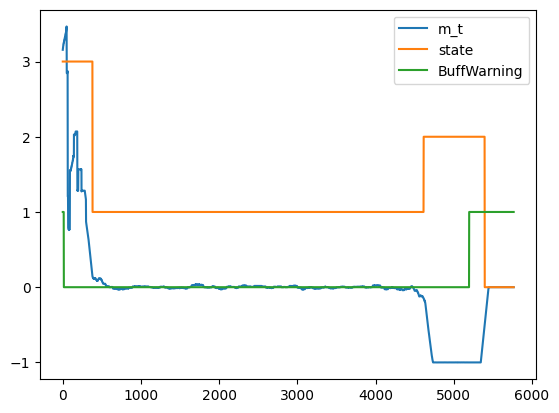

In [202]:
import matplotlib.pyplot as plt
# Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']
plt.plot(m,label='m_t')
plt.plot(status,label='state')
plt.plot(df_new["BuffWarning"],label='BuffWarning')
plt.legend()

In [152]:
import numpy as np
 ### 等会删掉
Dataset_List = ['A0']
###


Sum = 0
Num = [0 for _ in range(0, 4)]

MinTime_stall = 10
Thr_ss = 15
Resolution_List = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']
Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']

Stall_Threshold = 0.08
Delta = 0.0001
Epsilon = 0.15
T_smooth = 15
T_slope = 5
Buff_ss = 10
BuffWarningThresh = 20
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/' # 寻找到已经存为CSV的文件夹，在test_data下
    files = glob.glob(dataset_folder + '*.csv')
    files = files[0:1]
    for file in files:
        file_id = file.split('.')[0]
        df = pd.read_csv(file,low_memory=False)
        df_new = pd.DataFrame(columns=["EpochTime",  "BuffWarning", "status", "Resolution"])
        # Stall_Threshold = 0.08 #delta
        # Delta = 0.0001
        # Epsilon = 0.15
        # T_smooth = 15
        # T_slope = 5
        # Buff_ss = 10
        # BuffWarningThresh = 20
        hat_b = {}
        m = []
        status = []
        ## 要使用的存储df
        numpy_Resolution = np.array(df[Resolution_List])
        for i in numpy_RelativeTime:
            hat_b[round(i * 10) / 10]=np.median(numpy_BufferHealth[(numpy_RelativeTime >= (i - T_smooth - Delta)) & (numpy_RelativeTime <= (i + T_smooth + Delta))])
        maxTime = round(numpy_RelativeTime.max() * 10) / 10 # df的最后一个relativeTime的值
        for index, row in df.iterrows():
            if row["BufferValid"] == "-1":
                continue
            if index > 0:
                if row["EpochTime"] == df.iloc[index - 1]["EpochTime"] or 0 == df.iloc[index - 1]["EpochTime"]:
                    continue
            new_row = [row["EpochTime"]]
            t = round(row['RelativeTime'] * 10) / 10
            t_slope_1 = round((t + T_slope) * 10) / 10
            t_slope_2 = round((t - T_slope) * 10) / 10

            if t_slope_1 > maxTime:
                t_slope_1 = maxTime
            if t_slope_2 < 0:
                t_slope_2 = 0
        #     # print(t_slope_1, t_slope_2)
            Resolution = 0
            for i in range(len(Resolution_List)):
                if row[Resolution_List[i]] == 1:
                    Resolution = i
                    break
        #     # Resolutions.append(Resolution)
            # 计算mt
            mt = (hat_b[t_slope_1] - hat_b[t_slope_2]) / (t_slope_1 - t_slope_2)
            m.append(mt)
            b_t = row['BufferHealth']

            # BuffWarningThresh 以20作为分类标准 第71:6页
            if b_t < BuffWarningThresh:
                new_row.append(1)
            else:
                new_row.append(0)
            if b_t < Stall_Threshold:
                state = 0
            elif -Epsilon <= mt <= Epsilon and b_t > Buff_ss:
                state = 1
            elif mt < 0:
                state = 2
            else:
                state = 3
            Sum = Sum + 1
            Num[state] = Num[state] + 1
            new_row.append(state)
            status.append(state)
            new_row.append(Resolution)
            df_new.loc[len(df_new)] = new_row
        status = smooth_status(status, m)
        df_new['status'] = status
        print(df_new.iloc[1150:1155])
        # # df_new['BuffWarning'] = BuffWarnings
        # # df_new['Resolution'] = Resolutions
        # # print(df_new)
        # df_new.to_csv(file_id + '_label.csv', index=None, header=True)
        # print(file_id + '_tag.csv')
end = time.time()
print(f"Use {end - start}s")

600.9
          EpochTime  BuffWarning  status  Resolution
1150  1516209742696            0       1           4
1151  1516209742796            0       1           4
1152  1516209742896            0       1           4
1153  1516209742995            0       1           4
1154  1516209743096            0       1           4
Use 7.4486236572265625s


In [31]:
[1516209721996, 0, 1, 4]
[1516209722097, 0, 1, 4]
[1516209722197, 0, 1, 4]
[1516209722297, 0, 1, 4]
[1516209722397, 0, 1, 4]

LabelDataSet/A0\baseline_Jan17_exp_31_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_34_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_41_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_45_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_47_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_55_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_59_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_71_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_74_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_81_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_85_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_87_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_96_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_99_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_71_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_74_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_81_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_85_merged_label.csv
LabelDataS

In [122]:
df = pd.read_csv(file,low_memory=False)
df = df.iloc[0:5]

In [125]:
df.iloc[0:6]

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,q240p,q360p,q480p,q720p,q1080p,q1440p,q2160p,BufferHealth,BufferProgress,BufferValid
0,0.0,1,0,267,0,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
1,0.1,14,14,1957,6714,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
2,0.2,3,3,244,551,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
3,0.3,8,0,798,0,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
4,0.4,3,1,600,102,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1


In [ ]:
import pandas as pd
import numpy as np
from scapy.all import *
from math import *

GET_THRESH = 300 # bytes
DOWN_THRESH = 300  # bytes
VIDEO_CHUNK_GETSIZE = 700 # bytes
AUDIO_CHUNK_GETSIZE = 600 # bytes
NETINFO_NUM = 25

class Chunk():
    def __init__(self, start_time = 0, server_ip='',ttfb = 0, download_time = 0, slack_time = 0, get_size=0, chunk_size = 0, type="", protocol=""):
        self.start_time = start_time
        self.server_ip = server_ip
        self.ttfb = ttfb
        self.download_time = download_time
        self.slack_time = slack_time
        self.get_size = get_size
        self.chunk_size = chunk_size
        self.type = type
        self.protocol = protocol
    def __str__(self):
        return f"{self.start_time} {self.ttfb} {self.download_time} {self.slack_time} {self.get_size} {self.chunk_size} {self.type} {self.protocol}"
    def __repr__(self):
        return f"{self.start_time} {self.ttfb} {self.download_time} {self.slack_time} {self.get_size} {self.chunk_size} {self.type} {self.protocol}"


def isUplink(p):
    # IP = scapy.layers.inet.IP
    return p[IP].src.startswith('192.168.')

def detectAV(c):
    if abs(c.get_size-VIDEO_CHUNK_GETSIZE) > abs(c.get_size-AUDIO_CHUNK_GETSIZE):
        flag=0
    else:
        flag=1
    if c.chunk_size<=80*1024:
        flag=2
    return flag

def chunkDetection(filename):
    a = rdpcap(filename)
    meta_time = float(a[0].time)
    chunk = {}
    chunks = []
    downFlag = {}
    # IP = scapy.layers.inet.IP
    for p in a:
        if p.haslayer(IP):
            ipSrc=p[IP].src
            ipDst=p[IP].dst
            pLen=p[IP].len
            pHdr=p[IP].ihl*4
            ip_time=float(p.time)
            if isUplink(p) and pLen-pHdr > GET_THRESH:
                if ipDst in chunk:
                    chunk[ipDst].slack_time = ip_time - chunk[ipDst].download_time
                    avFlag=detectAV(chunk[ipDst])
                    if avFlag==0:
                        # chunk[ipDst].type='a'
                        chunks.append(chunk[ipDst])
                    elif avFlag==1:
                        # chunk[ipDst].type='v'
                        chunks.append(chunk[ipDst])
                    else:
                        chunk.pop(ipDst)
                        downFlag.pop(ipDst)
                chunk[ipDst] = Chunk(start_time=ip_time, get_size=pLen-pHdr, server_ip=ipDst)
                downFlag[ipDst] = False
            elif not isUplink(p) and pLen > DOWN_THRESH:
                if ipSrc in chunk:
                    if not downFlag[ipSrc]:
                        chunk[ipSrc].ttfb = ip_time
                        downFlag[ipSrc] = True
                    chunk[ipSrc].download_time = ip_time
                    chunk[ipSrc].chunk_size += pLen - pHdr
                    chunk[ipSrc].protocol = p.proto

    for c in chunk.values():
        avFlag=detectAV(c)
        if avFlag==0:
            # c.type='a'
            chunks.append(c)
        elif avFlag==1:
            # c.type='v'
            chunks.append(c)
    return meta_time, chunks

filename = 'RequetDataSetNew/A0/PCAP_FILES/baseline_Jan17_exp_31.pcap'
meta_time, chunks=chunkDetection(filename)

In [1]:
import pandas as pd
import random
import chunkdetection
import csv
import glob
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

# dataset_list=['A', 'B1', 'B2', 'C', 'D']

ans = []
# for dataset in dataset_list:
dataset_folder = 'LabelDataSet/A0/'
files = glob.glob(dataset_folder + '*_label.csv')
# cnt=0
for i in range(1):
    file_name = files[i]
    print("Processing file: " + file_name)
    # if (i >= len_list[dataset]):
    # 	break
    file = pd.read_csv(file_name)  # wxh's csv name
    print(os.path.split(file_name)[1].split('/')[-1][:-17])
    feature_file = 'RequetDataSetNew/' +'A0'+'/PCAP_FILES/' + os.path.split(file_name)[1].split('/')[-1][:-17] + '.pcap'  # yhy's pcap name
    feature_class = chunkdetection.ChunkDetection(feature_file)
    print(len(feature_class.getFeature(1516209864093)))

D:\Program\Anaconda\envs\dip2022\lib\site-packages\scapy\layers\ipsec.py:471: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
D:\Program\Anaconda\envs\dip2022\lib\site-packages\scapy\layers\ipsec.py:485: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,


Processing file: LabelDataSet/A0\baseline_Jan17_exp_31_merged_label.csv
baseline_Jan17_exp_31
Reading pcap file...
Parsing pcap file...


100%|█████████████████████████████████████████████████████████████████████████| 84540/84540 [00:02<00:00, 30921.88it/s]


120


In [2]:
feature_class.getFeature(1516209864093)

[2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 6,
 1524897.5,
 10.465993881225586,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 8,
 1445585.0,
 13.299987077713013,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 12,
 1464953.25,
 19.117595434188843,
 0,
 0,
 0,
 13,
 1400798.6923076923,
 19.849315404891968,
 0,
 0,
 0,
 14,
 1448151.642857143,
 21.706393480300903,
 0,
 0,
 0,
 16

In [34]:
import time
ans = []
start = time.time()
numpy_file = file.to_numpy()
lable_size = numpy_file.shape[0]
for i in range(0, lable_size, 50):
    feature = feature_class.getFeature(numpy_file[i,0])
    if not feature:
        continue
    feature.append(file_name + "-" + str(numpy_file[i,0]))
    feature.extend(numpy_file[i,1:])
    ans.append(feature)
end = time.time()
print(f'Use {end - start}s')
print(ans[15])

Use 4.6959614753723145s
[1, 1958394.0, 2.005246162414551, 0, 0, 0, 2, 1294669.0, 2.736966133117676, 0, 0, 0, 3, 1551026.0, 4.594044208526611, 0, 0, 0, 5, 1454741.0, 7.3903374671936035, 0, 0, 0, 5, 1454741.0, 7.3903374671936035, 0, 0, 0, 7, 1424870.4285714286, 9.905755281448364, 0, 0, 0, 9, 1396956.111111111, 13.018399238586426, 0, 0, 0, 13, 1141077.7692307692, 17.143291473388672, 3, 1152819.0, 2.8974967002868652, 17, 950886.4117647059, 27.476295232772827, 10, 1633147.3, 13.179170846939087, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'LabelDataSet/A0\\baseline_Jan17_exp_31_merged_label.csv-1516209702496', 0, 1, 4]


In [32]:
ans = []
start = time.time()
lable_size = file.shape[0]
for i in range(0, lable_size, 50):
    feature = feature_class.getFeature(file.iloc[i, 0])
    if not feature:
        continue
    feature.append(file_name + "-" + str(file.iloc[i, 0]))
    feature.extend(file.iloc[i, 1:])
    ans.append(feature)
end = time.time()
print(f'Use {end - start}s')
print(ans[15])

Use 4.498184680938721s
[1, 1958394.0, 2.005246162414551, 0, 0, 0, 2, 1294669.0, 2.736966133117676, 0, 0, 0, 3, 1551026.0, 4.594044208526611, 0, 0, 0, 5, 1454741.0, 7.3903374671936035, 0, 0, 0, 5, 1454741.0, 7.3903374671936035, 0, 0, 0, 7, 1424870.4285714286, 9.905755281448364, 0, 0, 0, 9, 1396956.111111111, 13.018399238586426, 0, 0, 0, 13, 1141077.7692307692, 17.143291473388672, 3, 1152819.0, 2.8974967002868652, 17, 950886.4117647059, 27.476295232772827, 10, 1633147.3, 13.179170846939087, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 'LabelDataSet/A0\\baseline_Jan17_exp_31_merged_label.csv-1516209702496', 0, 1, 4]


In [6]:
numpy_file = file.to_numpy()

In [15]:
numpy_file[i,1:]

array([1, 3, 4], dtype=int64)

In [12]:
feature

NameError: name 'feature' is not defined

In [13]:
feature_class.getFeature(1516209864093)

[2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 6,
 1524897.5,
 10.465993881225586,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 8,
 1445585.0,
 13.299987077713013,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 12,
 1464953.25,
 19.117595434188843,
 0,
 0,
 0,
 13,
 1400798.6923076923,
 19.849315404891968,
 0,
 0,
 0,
 14,
 1448151.642857143,
 21.706393480300903,
 0,
 0,
 0,
 16

In [3]:
import numpy as np
a = np.array([1,2,3,4,5])

In [11]:
for i in range(5):
    print(a[a>i])

[1 2 3 4 5]
[2 3 4 5]
[3 4 5]
[4 5]
[5]


In [12]:
from matplotlib.pyplot import text
import pandas as pd
import random
import csv
import joblib
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
train_times=10# 在训练集中建立train_times个随机森林，选择训练集中表现最好的用来跑test
Tree_num=80#随机森林里树的个数

train_file_name='test_data/test_data.csv'
train_file=pd.read_csv(train_file_name)

In [16]:
train_file.iloc[:,:-4]

,label0,label1,label2,label3,label4,label5,label6,label7,label8,label9,...,label110,label111,label112,label113,label114,label115,label116,label117,label118,label119
0,6,4.629428e+05,11.650978,8,1576899.00,9.220158,-1,-1.000000e+00,-1.000000,-1,...,-1.000000,-1,-1.0,-1.0,-1,-1.000000,-1.000000,-1,-1.000000,-1.000000
1,6,4.726043e+05,6.821882,4,1257938.75,5.230437,8,4.490580e+05,14.457896,10,...,-1.000000,-1,-1.0,-1.0,-1,-1.000000,-1.000000,-1,-1.000000,-1.000000
2,2,8.152340e+05,2.856864,0,0.00,0.000000,7,4.240593e+05,11.918181,7,...,-1.000000,-1,-1.0,-1.0,-1,-1.000000,-1.000000,-1,-1.000000,-1.000000
3,2,1.299256e+06,3.112644,0,0.00,0.000000,6,8.099863e+05,7.237536,4,...,-1.000000,-1,-1.0,-1.0,-1,-1.000000,-1.000000,-1,-1.000000,-1.000000
4,3,1.562799e+06,5.031307,0,0.00,0.000000,5,1.263773e+06,7.888171,0,...,-1.000000,-1,-1.0,-1.0,-1,-1.000000,-1.000000,-1,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11124,0,0.000000e+00,0.000000,0,0.00,0.000000,0,0.000000e+00,0.000000,0,...,49.460778,0,0.0,0.0,17,884018.294118,51.069417,6,822185.833333,11.036120
11125,0,0.000000e+00,0.000000,0,0.00,0.000000,0,0.000000e+00,0.000000,0,...,49.460778,0,0.0,0.0,17,884018.294118,51.069417,3,796124.333333,4.929644
11126,0,0.000000e+00,0.000000,0,0.00,0.000000,0,0.000000e+00,0.000000,0,...,48.769905,0,0.0,0.0,14,822232.928571,49.460778,0,0.000000,0.000000
11127,0,0.000000e+00,0.000000,0,0.00,0.000000,0,0.000000e+00,0.000000,0,...,48.769905,0,0.0,0.0,13,748100.076923,48.769905,0,0.000000,0.000000


In [51]:
train_file.iloc[:,-2]

0        3
1        3
2        3
3        3
4        3
        ..
11124    2
11125    2
11126    0
11127    0
11128    0
Name: BuffWarning, Length: 11129, dtype: int64

In [37]:
x_train,x_test,y_train,y_test = train_test_split(train_file.iloc[:,:-4],train_file.iloc[:,-3],test_size=0.3,random_state=2022)#test_size：用来控制选择训练集里test_s

In [38]:
x_train.shape

(7790, 120)

In [39]:
x_test.shape

(3339, 120)

In [41]:
y_train

3327    0
4080    0
1395    0
7838    1
5208    0
       ..
6384    0
4720    0
173     0
1244    0
4989    0
Name: status, Length: 7790, dtype: int64

In [42]:
y_test

8002     0
11051    1
426      0
10538    0
7227     0
        ..
4972     0
8976     0
10453    0
4721     0
7865     0
Name: status, Length: 3339, dtype: int64

In [43]:
RF=RandomForestClassifier(n_estimators=Tree_num)

In [44]:
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)
accuracy=accuracy_score(y_pred,y_test)

In [45]:
print(accuracy)

0.9598682240191674


In [49]:
train_times=10# 在训练集中建立train_times个随机森林，选择训练集中表现最好的用来跑test
for j in range(train_times):
	rf=RandomForestClassifier(n_estimators=Tree_num)
	rf.fit(x_train,y_train)
	tmp_y_pred=rf.predict(x_test)
	if accuracy<accuracy_score(tmp_y_pred,y_test):
	    y_pred=tmp_y_pred
	    accuracy=accuracy_score(tmp_y_pred,y_test)
	    RF=rf

In [50]:
print(accuracy)

0.9610661874812818


In [82]:
from matplotlib.pyplot import text
import pandas as pd
import random
import csv
import joblib
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
Tree_num=100#随机森林里树的个数
x_train,x_test,y_train,y_test = train_test_split(train_file.iloc[:,:-4],train_file.iloc[:,-3],test_size=0.2,random_state=2022)
RF = RandomForestClassifier(n_estimators=Tree_num)
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred,average=None)
recall = recall_score(y_test,y_pred,average=None)

In [83]:
print(f'accuracy:{accuracy}, precision:{precision}, recall:{recall}')

accuracy:0.9604672057502246, precision:[0.96489417 0.93079585], recall:[0.98941239 0.79821958]


In [84]:

test_file_name='test_data/test_data.csv'#test文件名
test_file=pd.read_csv(test_file_name)
X_test=test_file.iloc[:,:-4]

In [87]:
name_list=["Status", "BuffWarning", "Resolution"]
i = -3
RF = joblib.load('traindata/RF_'+name_list[i] + '_large.pkl')
Y_test=test_file.iloc[:,i]
Y_pred=RF.predict(X_test)
accuracy=accuracy_score(Y_pred,Y_test)
precision = precision_score(y_test,y_pred,average=None)
recall = recall_score(y_test,y_pred,average=None)
print(f'accuracy:{accuracy}, precision:{precision}, recall:{recall}')

accuracy:0.9103243777518196, precision:[0.96489417 0.93079585], recall:[0.98941239 0.79821958]


D:\Program\Anaconda\envs\dip2022\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Program\Anaconda\envs\dip2022\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [1]:
import pandas as pd
import random
import chunkdetection
import csv
import glob
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

# dataset_list=['A', 'B1', 'B2', 'C', 'D']

ans = []
# for dataset in dataset_list:
dataset_folder = 'LabelDataSet/A0/'
files = glob.glob(dataset_folder + '*_label.csv')
# cnt=0
for i in range(1):
    file_name = files[i]
    print("Processing file: " + file_name)
    # if (i >= len_list[dataset]):
    # 	break
    file = pd.read_csv(file_name)  # wxh's csv name
    print(os.path.split(file_name)[1].split('/')[-1][:-17])
    feature_file = 'RequetDataSetNew/' +'A0'+'/PCAP_FILES/' + os.path.split(file_name)[1].split('/')[-1][:-17] + '.pcap'  # yhy's pcap name
    feature_class = chunkdetection.ChunkDetection(feature_file)



D:\Program\Anaconda\envs\dip2022\lib\site-packages\scapy\layers\ipsec.py:471: CryptographyDeprecationWarning: Blowfish has been deprecated
  cipher=algorithms.Blowfish,
D:\Program\Anaconda\envs\dip2022\lib\site-packages\scapy\layers\ipsec.py:485: CryptographyDeprecationWarning: CAST5 has been deprecated
  cipher=algorithms.CAST5,


Processing file: LabelDataSet/A0\baseline_Jan17_exp_31_merged_label.csv
baseline_Jan17_exp_31
Reading pcap file...
Parsing pcap file...


100%|█████████████████████████████████████████████████████████████████████████████| 84540/84540 [00:02<00:00, 30981.50it/s]


In [2]:
feature_class.getFeature(1516209864093)

2
2
2
3
3
5
5
6
7
7
8
9
9
11
11
11
12
13
14
16


[2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 2,
 1279861.0,
 2.74914288520813,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 3,
 1492881.6666666667,
 4.736539840698242,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 5,
 1412717.6,
 8.965434789657593,
 0,
 0,
 0,
 6,
 1524897.5,
 10.465993881225586,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 7,
 1564473.857142857,
 12.488471984863281,
 0,
 0,
 0,
 8,
 1445585.0,
 13.299987077713013,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 9,
 1495504.4444444445,
 15.083724021911621,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 11,
 1420095.0,
 17.112349271774292,
 0,
 0,
 0,
 12,
 1464953.25,
 19.117595434188843,
 0,
 0,
 0,
 13,
 1400798.6923076923,
 19.849315404891968,
 0,
 0,
 0,
 14,
 1448151.642857143,
 21.706393480300903,
 0,
 0,
 0,
 16